In [180]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from glob import glob
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import sympy as sp

In [181]:
def is_in_notebook():
    import sys
    return 'ipykernel' in sys.modules

def clear_output():
    """
    clear output for both jupyter notebook and the console
    """
    import os
    os.system('cls' if os.name == 'nt' else 'clear')
    if is_in_notebook():
        from IPython.display import clear_output as clear
        clear()
        
print('bbb')
clear_output()

In [182]:
def light_curve(lc_dir,look=False):
    data = np.genfromtxt(lc_dir,names="time,flux,et,ef")
    good = (data['ef'] == 0)
    time_diff = data['time'][good][1:] - data['time'][good][:-1]
    
    if (np.max(time_diff) < 10):
        error_point = np.argmax(time_diff)

        time = np.append(data['time'][good][5:error_point-5],data['time'][good][error_point+5:-5])
        flux = np.append(data['flux'][good][5:error_point-5],data['flux'][good][error_point+5:-5])
        et = np.append(data['et'][good][5:error_point-5],data['et'][good][error_point+5:-5])
        
        min_flux = np.min(np.append(flux[int(len(flux)*0.05):int(len(flux)*0.4)],\
                                    flux[int(len(flux)*0.6):-int(len(flux)*0.05)]))
        
        norm_flux = (flux - np.median(flux))/(np.median(flux) - min_flux)
#         norm_flux = flux/np.median(flux)
        norm_et = et / np.abs(np.median(flux) - min_flux)

        if look == True:
            plt.figure(figsize=(10,5))
            plt.plot(time,norm_flux,'c')
            plt.xlabel('time');plt.ylabel('flux')
            plt.show()
        else:
            None
        
        w = (norm_flux < 0.1) & (norm_flux > -1.2)
#         w = (norm_flux < 1.03) & (norm_flux > 0.75)
        return time[w],norm_flux[w],norm_et[w]

    else:
        return "bad_data","bad_data","bad_data"



def mulit_light_curve(lc_dir,look=False):
    time = []; flux = []; et = []
    size = 0
    for i in range(10):
        test_dir = lc_dir[:-9] + "0%s" %i + "_LC.txt"
        if os.path.exists(test_dir) == True:
            t,f,e = light_curve(test_dir)
            if t == 'bad_data':
                None
            else:
                time.extend(t)
                flux.extend(f)
                et.extend(e)
                size += 1
        else:
            None

    for i in range(10):
        test_dir = lc_dir[:-9] + "1%s" %i + "_LC.txt"
        if os.path.exists(test_dir) == True:
            t,f,e = light_curve(test_dir)
            if t == 'bad_data':
                None
            else:
                time.extend(t)
                flux.extend(f)
                et.extend(e)
                size += 1
        else:
            None
            
    if size > 2:
        if look == True:
            plt.figure(figsize=(5*size,5))
            plt.plot(time,flux,'c')
            plt.plot(time,flux,'r.')
            plt.xlabel('time');plt.ylabel('flux')
            plt.grid()
            plt.show()
        else:
            None
    else:
        None

    return time, flux, et

In [200]:
def sec_poly(x,a,b,c):
    y = a*x**2+b*x+c
    return y

def fourth_poly(x,a,b,c,d,e):
    y = a*x**4+b*x**3+c*x**2+d*x+e
    return y

def root_4th_poly(a,b,c,d):
    x = sp.Symbol('x')
    f = 4*a*(x**3) + 3*b*(x**2) + 2*c*(x) + d
    root = sp.solve(f)
    r = [complex(root[0]).real,complex(root[1]).real,complex(root[2]).real]
    mid = r[np.argmin(np.abs(r))]
    return mid
    

def primary_eci(time,flux,period,eci_1st=0):
    
    # find the minimum flux in first period to be the first primary eclipse
    
    if eci_1st == 0:
        peaks = find_peaks(-flux, height=0.4)
        peaks_pos = peaks[0]
        eci_1st = time[peaks_pos][0]
    else:
        None
    
    w = (time > eci_1st-0.75*period) & (time < eci_1st+0.75*period)
    if len(flux[w]) > 0:
        tp = np.argmin(flux[w])
        t = time[w][tp]
        while t > (time[0]-period):
            t -= period
        return t
    else:
        return eci_1st
        
    
def find_eclipse(lc_dir,period,eci_1st=0,look=False):
    time, flux, et = mulit_light_curve(lc_dir)
    time = np.array(time); flux = np.array(flux); et = np.array(et) #set list to array
    
    prim_eci = primary_eci(time,flux,period,eci_1st)

    ck_time = np.arange(prim_eci,time[-1],period) #check each period from the begining of first eclipse
    p1_time = []; p1_flux = []; p_time = []; p_flux = []
    for i in range(len(ck_time)):
        tn = ck_time[i]
        tr = ((tn - 0.15*period) < time) & (time < (tn + 0.15*period)) #create a box around eclipse to fit
        if len(time[tr] > 5):
            mid_pos = np.argmin(flux[tr]) #mid eclipse position in time range
            left_pos = 0;right_pos = 0; 
            while (flux[tr][mid_pos-left_pos] < -0.2) & ((left_pos + 2) < mid_pos):
                left_pos += 1
            while (flux[tr][mid_pos+right_pos] < -0.2) & ((right_pos + 2) < (len(flux[tr]) - mid_pos)):
                right_pos += 1
            lp = mid_pos-left_pos #left eclipse position in time range
            rp = mid_pos+right_pos #right eclipse position in time range

            duration = right_pos+left_pos #number of point during eclipse
            if (np.min(flux[tr]) < -0.5) & (left_pos > 1) & (right_pos > 1):
                x = time[tr][lp:rp] - time[tr][mid_pos]
                y = flux[tr][lp:rp]
                testx = np.linspace(x-0.3,x+0.3,100)

                if duration < 5: #  2nd poly fitting
                    popt, pcov = curve_fit(sec_poly, x, y, p0=[100,0,-0.5])

                    if popt[0] <= 0:
                        continue

                    peak_x = -0.5*popt[1]/popt[0]
                    peak_y = sec_poly(peak_x,popt[0],popt[1],popt[2])
                    testy = sec_poly(testx,popt[0],popt[1],popt[2])
                    # uncertainty
                    peak_ex = np.sqrt((1/popt[0])**2*pcov[1,1]**2+(popt[1]/popt[0]**2)**2*pcov[0,0]**2)
                    
                else: #  4th poly fitting
                    popt, pcov = curve_fit(fourth_poly, x, y, p0=[100,0,0,0,-0.9])

#                     if popt[0] >= 0:
#                         continue
                    peak_x = root_4th_poly(popt[0],popt[1],popt[2],popt[3])
                    peak_y = fourth_poly(peak_x,popt[0],popt[1],popt[2],popt[3],popt[4])
                    testy = fourth_poly(testx,popt[0],popt[1],popt[2],popt[3],popt[4])

#################  check each fitting #################
                
#                 plt.plot(testx,testy,'c-')
#                 plt.plot(peak_x,peak_y,'ko')
#                 plt.plot(time[tr]-time[tr][mid_pos],flux[tr],'r.')
#                 plt.ylim(-1.5,0.2)
#                 plt.show()
                
#######################################################
                
    
#################  append time and flux ###############

                p1_time.append(time[tr][np.argmin(flux[tr])]) # local minimum record
                p1_flux.append(np.min(flux[tr]))

                p_time.append(peak_x+time[tr][mid_pos]) # fitting time
                p_flux.append(peak_y)
                
#######################################################
                

#################  check peak position ####################

    if look == True:
        plt.figure(figsize=(25,5))
        plt.plot(time,flux,'c.-')
        plt.plot(p_time,p_flux,'rx')
        plt.plot(p1_time,p1_flux,'b.')
#         plt.xlim(3550,3650)
        plt.ylim(-1.25,0.2)
        plt.xlabel('time')
        plt.ylabel('normlized flux')
        plt.show()
    
###########################################################
    
    return p_time

In [201]:
def Phase_cycle(t,P,T_0):
    T_diff = np.array(t) - T_0
    I = np.floor(T_diff/P)
    phi = (T_diff/P) - I
    return phi, I #phase and cycle


def sing_dc_func(guess_P,time,norm_flux,norm_et,fir_eci,look=False):
    phi, I = Phase_cycle(time, guess_P, (fir_eci+0.3*guess_P))
    phase_flux = np.stack((phi,norm_flux),axis=-1)
    phase_flux = np.array(sorted(phase_flux,key=lambda x:x[0]))
    phase = phase_flux[:,0]
    flux = phase_flux[:,1]

    if look == True:
        plt.figure(figsize=(15,5))
        plt.title('period = %s'%(guess_P))
        plt.plot(phase,flux,'c-')
        plt.plot(phase,flux,'r.')
        plt.xlabel('phase');plt.ylabel('flux')
        plt.show()        
    
    S = np.fabs(flux[-1] - flux[0]) + np.sum(np.fabs(flux[1:] - flux[:-1]))
    return S/47.-2.,phase,flux

In [202]:
def Phase_cycle2(t,P,T_0):
    T_diff = np.array(t) - T_0
    I = np.round(T_diff/P)
    phi = (T_diff/P) - I
    return phi, I #phase and cycle

def first_poly(x,a,b):
    y = a*x+b
    return y


def check_eci(lc_dir,period,eperiod,eci_1st=0,look=False):
    p_time = np.array(find_eclipse(lc_dir,period,eci_1st,look))
    if len(p_time) > 6:
        phi,I = Phase_cycle2(p_time,period,p_time[0])
    
        popt, pcov = curve_fit(first_poly, I, p_time)
        testy = first_poly(I,popt[0],popt[1])
        res = p_time-testy
        
        med = np.median(res)
        std = np.std(res)
        w = (res > (med - 5*std)) & (res < (med + 5*std)) & (res > -0.25) & (res < 0.25)
        
        if len(p_time[w]) > 6:
            popt, pcov = curve_fit(first_poly, I[w], p_time[w])
            testy = first_poly(I[w],popt[0],popt[1])
            res = p_time[w]-testy

            if look == True:
                plt.figure(figsize=(10,4))
                plt.plot(I[w],res,'r.-')
                plt.title('period = %s'%popt[0])
                plt.ylabel('phase')
                plt.xlabel('cycle')
                plt.show()
        else:
            None
            
        if len(p_time[w]) > 0:
            eci_1st = p_time[w][0]
        else:
            eci_1st = p_time[0]

        return p_time[w],popt[0],np.sqrt(pcov[0,0]),eci_1st
    else:
        return None,period,eperiod,eci_1st

In [203]:
binary_period = np.genfromtxt('/Users/laote/sdsu/Research/binary/curve_bin/binary_list.txt',dtype=str,skip_header=1)
tic_name = binary_period[:,0]
period = binary_period[:,1].astype(float)
eperiod = binary_period[:,2].astype(float)
first_eci = binary_period[:,3].astype(float)

sort800 =  glob("/Users/laote/sdsu/Research/binary/curve_bin/1600K_Curve_binary/*.txt")
bbb = []
ccc = []
for a in sort800:
    if a[-28:-14] in tic_name:
        if a[-28:-14] not in ccc:
            bbb.append(a)
        ccc.append(a[-28:-14])
bbb = sorted(bbb, key=lambda name: int(name[-25:-14] + name[-10:-7]))
print(len(bbb))
        
period_v3 = []
first_eci_v3 = [] 
eperiod_v3 = []
for i in range(len(bbb)):
    period_v3.append(period[np.argwhere(tic_name == bbb[i][-28:-14])[0][0]])
    eperiod_v3.append(eperiod[np.argwhere(tic_name == bbb[i][-28:-14])[0][0]])
    first_eci_v3.append(first_eci[np.argwhere(tic_name == bbb[i][-28:-14])[0][0]])
bbb = np.array(bbb)
period_v3 = np.array(period_v3)
first_eci_v3 = np.array(first_eci_v3)
eperiod_v3 = np.array(eperiod_v3)

no0_999 = (eperiod_v3 != 0) & (eperiod_v3 != 999)
bbb = bbb[no0_999]
period_v3 = period_v3[no0_999]
first_eci_v3 = first_eci_v3[no0_999]
eperiod_v3 = eperiod_v3[no0_999]
print(len(bbb))

1008
911


In [208]:
# eci_time = dict()
period_v4 = []
for i in range(len(eci_time),911):
#     print(bbb[i],period_v3[i],first_eci_v3[i])
    name = bbb[i][-28:-14]
    prim_eci,p,ep,fir_eci = check_eci(bbb[i],period_v3[i],eperiod_v3[i],first_eci_v3[i],look=True)
    eci_time[name] = prim_eci
    period_v4.append([name,p,ep,fir_eci])
    print(i)
    if i%20 == 0:
        clear_output()
np.save('eci_time',eci_time)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:58: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


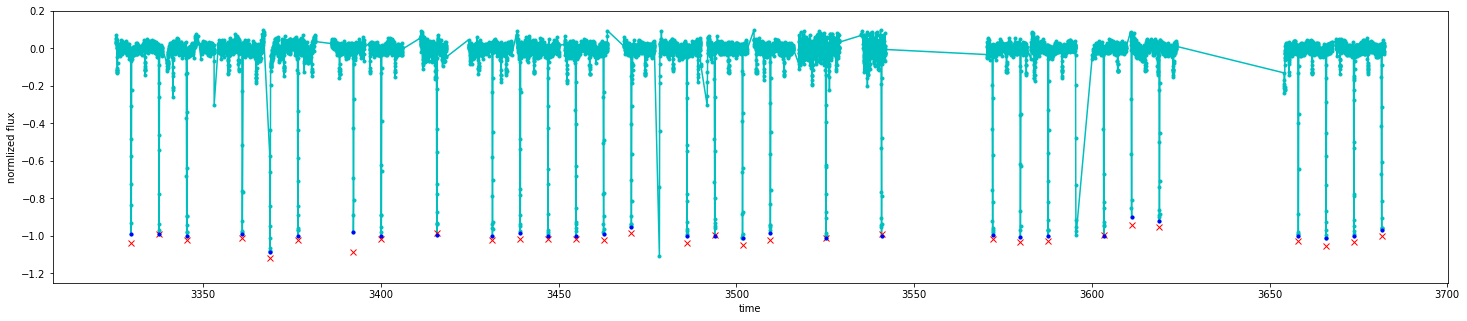

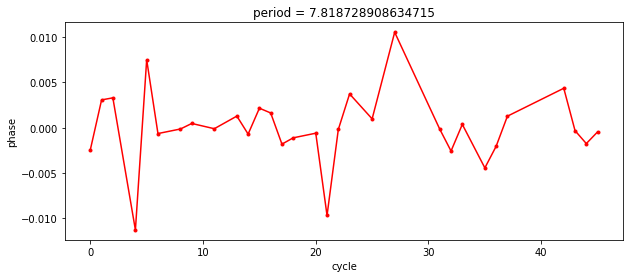

In [204]:
checkdir = '/Users/laote/sdsu/Research/binary/curve_bin/Binary_ck/tic00041088200_SEC002_LC.txt'

p245 = check_eci(checkdir, 7.8187447,3325,look=True)

In [134]:
# period_v4 = np.load('./curve_bin/1600k_period_v4.npy')
# if os.path.exists('1600k_period_v5.npy'):
#     period_v5 = np.load('1600k_period_v5.npy')
#     print("Success loading old file.")
# else:
#     period_v5 = []
# period_v5 = np.array(period_v5)
# for i in range(len(period_v5),926):
#     name,p723,ep723,fe723 = period_v4[i]
#     p723 = np.float(p723);fe723 = np.float(fe723)
# #     p723 = p723/2
#     allname = glob("/Users/laote/sdsu/Research/binary/curve_bin/1600K_Curve_binary/%s*.txt"%(name))
#     lc_dir = allname[0]
#     print(lc_dir,p723,fe723)
#     t723, f723, et723 = mulit_light_curve(lc_dir,look=True)
#     sing_dc_func(p723,t723,f723,et723,fe723,look=True)
#     folding_ok = input('period %f in folding need double or half? (d or h): '%p723)
#     if folding_ok == 'd':
#         period = 2*p723
#     elif folding_ok == 'h':
#         period = 0.5*p723
#     elif folding_ok == 'l':
#         ep723 = 999
#     elif folding_ok == 'g':
#         period = input('Give a guass period: ')
#         period = np.float(period)
#     else:
#         period = p723
#     print(period)
#     test = np.array([[name,period,ep723,fe723]])
#     if len(period_v5) != 0: #check empty
#         if name in period_v5[:,0]: #delete old data
#             row_num = np.argwhere(period_v5[:,0] == bn)[0][0]
#             period_v5 = np.delete(period_v5, row_num, 0)
#         else:
#             None

#         period_v5 = np.vstack((test,period_v5))
#         np.save('1600k_period_v5',period_v5)
#     else:
#         period_v5 = test
#         np.save('1600k_period_v5',period_v5)
#     clear_output()

In [ ]:
checkdir = '/Users/laote/sdsu/Research/binary/curve_bin/1600K_Curve_binary/tic00262576400_SEC002_LC.txt'
# checkdir = '/Users/laote/sdsu/Research/binary/curve_bin/1600K_Curve_binary/tic00141413795_SEC011_LC.txt'

t723, f723, et723 = mulit_light_curve(checkdir,look=True)
sing_dc_func(0.26935,t723,f723,et723,3353.483,look=True)
# sing_dc_func(0.99158,t723,f723,et723,3355.249,look=True) 

In [323]:
# for key in eci_time:
#     if np.array(eci_time[key]).dtype == 'float64':
#         f = open('./curve_bin/Binary_pe/%s.txt'%(key),'w')
#         for ele in eci_time[key]: 
#             f.write('%.5f\n'%(ele))
#         f.close()